# Import modules

In [25]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [26]:
# Add at the beginning of your notebook to make imports work
import sys
import os

# Get the absolute path to the project root directory (one level up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to Python's import path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

In [27]:
project_root

'/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon'

In [28]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [29]:
from config.params import FusionParams
from config.initialize_simulation import initialize_state
from model.agents_class import AgentStake
from model.rewards import calculate_reward_allocation
from model.stochastic_processes import create_stochastic_avail_price_process, plot_price

from real_data_fetcher import fetch

from config.psub import psub


# Price Traj Generation

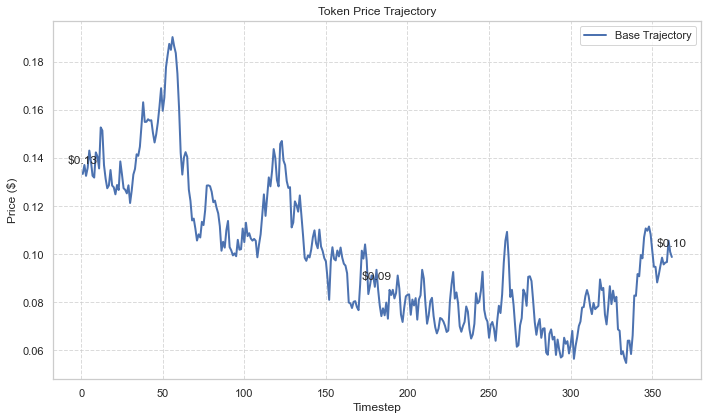

0.0547799771611989


<Figure size 432x288 with 0 Axes>

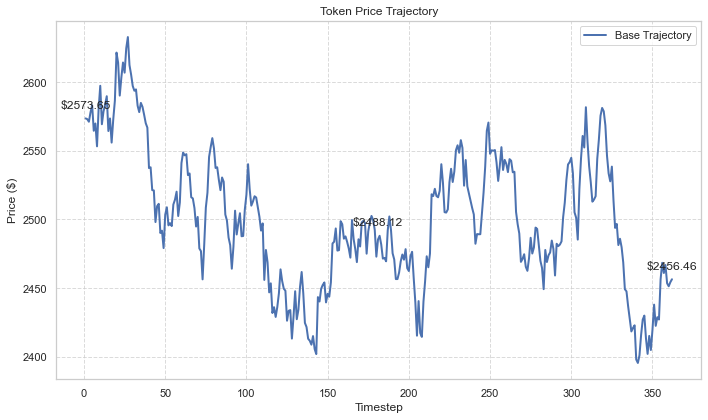

2395.482395291351


<Figure size 432x288 with 0 Axes>

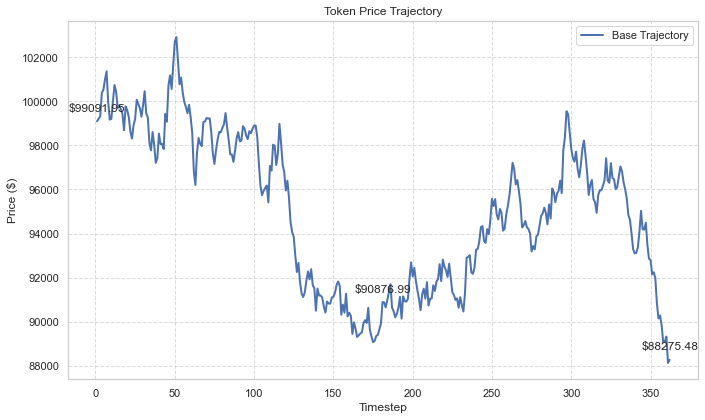

88130.95894954733


<Figure size 432x288 with 0 Axes>

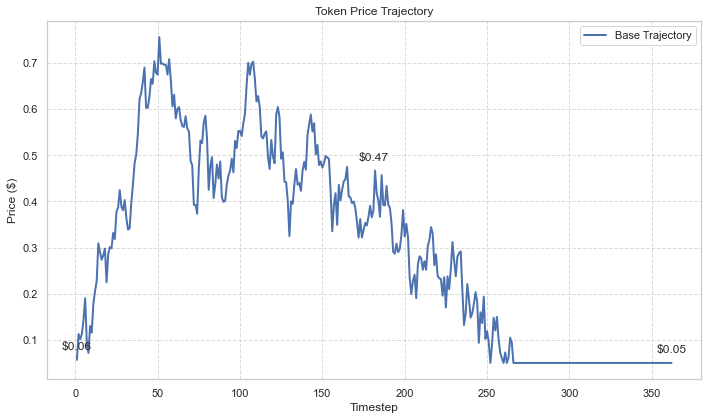

0.05


<Figure size 432x288 with 0 Axes>

In [30]:
# types
Run = int
Timestep = int

avl_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0)


# from config.config import (
#     TIMESTEPS,
#     DELTA_TIME,
# )
# avl_price_samples = [0.1] * TIMESTEPS

plot_price(avl_price_samples)
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=1500, target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples)
print(min(eth_price_samples))

btc_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=65000, target_avg=95000, maximum_avl_price=110000)
plot_price(btc_price_samples)
print(min(btc_price_samples))

# please ignore lens price simulation rn
lens_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.3, maximum_avl_price=2, volatility=3.0)
plot_price(lens_price_samples)
print(min(lens_price_samples))


In [31]:
# avl_price_samples, eth_price_samples, Timestep = fetch(symbol_avl='hawk')

# plot_price(avl_price_samples) 
# print(min(avl_price_samples))

# plot_price(eth_price_samples) 
# print(min(eth_price_samples))

# Setup

In [32]:
# intial token prices
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.133356799836525


In [33]:
# Fixed parameters: to get initial total fdv
def fixed_params(total_supply = 10_000_000_000, avl_price = AVL_initial_price):
    total_fdv = total_supply * avl_price
    return total_fdv

init_total_fdv = fixed_params(avl_price = AVL_initial_price)



In [34]:
constants = {
    "total_supply": 10_000_000_000,
    "init_total_fdv": init_total_fdv,
    "native_staking_ratio": 0.5,
}

In [35]:
## create maxi agents with initial composition
## but set epsilon numbers (<=1) for cold start
agents = AgentStake.create_maxi_agents(
    target_composition={'AVL': 0, 'ETH': 1, 'BTC': 0},  
    total_tvl=1  # $1M total TVL
)

In [36]:
rewards_result = calculate_reward_allocation(
    constants=constants,
    avl_price=0.1,
    total_tvl=250e6,
    avl_stake_pct=0.15,
    target_avl_yield=0.15,
    target_eth_yield=0.035
)



# Simulation

In [37]:
# system parameters
parameters = FusionParams(
    constants=[constants],  # Wrap in list for multiple runs
    avl_price_samples=[avl_price_samples],  # List of price trajectories
    eth_price_samples=[eth_price_samples],
    btc_price_samples=[btc_price_samples],
    lens_price_samples=[lens_price_samples],
    rewards_result=[rewards_result],  # List of reward results
    agents=[agents],  # List of agent configurations
    btc_activation_day=[180]
).__dict__

params = parameters


In [38]:
# initial conditions

initial_conditions = initialize_state(init_total_fdv, constants, rewards_result, params,restaking = 1, seed = 0)


In [39]:
# Add validation checks
assert len(parameters['avl_price_process']) == 1, "Should have 1 price process"
assert parameters['avl_price_process'][0](0) == avl_price_samples[0], "Price mismatch"
#assert 'run' in initial_conditions, "Missing run key in initial state"



In [40]:
# run simulation

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

simulation=Simulation(model=model, timesteps=600, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results  = experiment.run()
df= pd.DataFrame(results)


###########################
timestep 0
[DEBUG] update_token_prices
{'avl_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=np.float64(1.0), balance=9000000.0, price=np.float64(0.133356799836525)), 'ETH': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(2573.649870970514)), 'BTC': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(99091.94503603829))}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0, restake_pct=1), 'eth_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(0.133356799836525)), 'ETH': AssetAllocation(pct=np.float64(1.0), balance=300, price=np.float64(2573.649870970514)), 'BTC': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(99091.94503603829))}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0, restake_pct=1), 'btc_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=np.float64(0.133356799836525)), 'ETH': AssetAllocation(pct=0.0, balance=0, price=np.fl

In [41]:
print(df)
df.to_csv('simulation_results.csv', index=False, encoding='utf-8')

      timestep                                             agents  \
0            0  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
1            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
2            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
3            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
...        ...                                                ...   
5396       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
5397       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
5398       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
5399       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
5400       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   

                                           pool_manager  \
0     PoolManager(total_budget=30000000000.0, pools=...   
1     PoolManager(total_budget=30000000000.0, pools=.

# Visualizations

In [42]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
        0: "downside",
    }
)

In [43]:
fig= visualizations.plot_total_security(
    df
)
pio.show(fig)

In [44]:
fig = visualizations.plot_avg_overall_yield(
    df
)
pio.show(fig)


In [45]:
fig = visualizations.plot_yield_pct(
    df
)
pio.show(fig)

In [46]:
fig= visualizations.plot_staking_ratio_inflation_rate(
    df,
    assets=['AVL', 'ETH', 'BTC']
)
pio.show(fig)


In [47]:
fig = visualizations.plot_pool_rewards_spent(
    df
)
pio.show(fig)  

In [48]:
fig = visualizations.plot_asset_tvl_stacked(
    df
)
pio.show(fig)  